# UCI HAR - classification
- https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

#### 데이터 종류
- 561개 특성으로 전처리된 메인 데이터셋(X_train, X_test)
- Inertial Signals 데이터셋: 원시 센서 값(raw signal)

#### Inertial Signals 데이터 구조
- 각 파일은 행 = 샘플(segment), 열 = 시계열 프레임을 의미
- 각 샘플은 2.56초 길이 (샘플링 주파수 50Hz, 128 타임스텝 → 128 / 50 = 2.56초)
- 이미 샘플링이 되어 있으므로(7352개의 샘플) split_sequence() 사용하지 않아도 됨
- 한 행이 (128,) 길이의 시계열 벡터
- 세 축(X, Y, Z)와 센서 종류(acc, gyro)로 분리되어 있음

#### 센서 및 값의 의미
- Total acceleration (total_acc): 스마트폰 가속도계로 측정한 총 가속도 (중력 + 신체 움직임 포함)
- Body acceleration (body_acc): 총 가속도에서 중력 성분을 제거한 값 (실제 동작 가속도)
- Gyroscope (body_gyro): 각속도(회전 속도), 단위는 rad/sec, 스마트폰의 자이로스코프 센서 값

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [ ]:
TRAIN = "train/"
TEST = "test/"

DATASET_PATH = "/content/drive/MyDrive/AI_data/UCI HAR Dataset/"

# Load "X"
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []  # 한 센서축 데이터 전체 저장

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ') # 공백 2개를 1개로
                row_clean = row_clean.strip() # 양쪽 공백 제거
                serie = row_clean.split(' ') # 공백 기준 split
                serie_array = np.array(serie, dtype=np.float32) # float32 numpy 배열로 변환
                series_list.append(serie_array) # 시퀀스 추가

        # 하나의 센서축 데이터 추가 (feature)
        X_signals.append(series_list)

    # shape: (특성 수, 샘플 수, 타임스텝 수)
    X_signals = np.array(X_signals)
    # shape 변환 → (샘플 수, 타임스텝 수, 특성 수)
    return np.transpose(X_signals, (1, 2, 0))


X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("첫 번째 샘플 데이터:\n", X_train[0])


X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
첫 번째 샘플 데이터:
 [[ 1.808515e-04  1.076681e-02  5.556068e-02 ...  1.012817e+00
  -1.232167e-01  1.029341e-01]
 [ 1.013856e-02  6.579480e-03  5.512483e-02 ...  1.022833e+00
  -1.268756e-01  1.056872e-01]
 [ 9.275574e-03  8.928878e-03  4.840473e-02 ...  1.022028e+00
  -1.240037e-01  1.021025e-01]
 ...
 [-1.147484e-03  1.714439e-04  2.647864e-03 ...  1.018445e+00
  -1.240696e-01  1.003852e-01]
 [-2.222655e-04  1.574181e-03  2.381057e-03 ...  1.019372e+00
  -1.227451e-01  9.987355e-02]
 [ 1.575500e-03  3.070189e-03 -2.269757e-03 ...  1.021171e+00
  -1.213260e-01  9.498741e-02]]


In [ ]:
# Load "y"

def load_y(y_path):
    with open(y_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    # 라벨을 0부터 시작하도록 -1 (원래 라벨이 1부터 시)
    return np.array(labels, dtype=np.int32) - 1


y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y_train[:5])

y_train shape: (7352,)
y_test shape: (2947,)
[4 4 4 4 4]


In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = 6

model = Sequential([
            Input(shape=input_shape),
            LSTM(128, return_sequences=True, dropout=0.2),
            LSTM(64, return_sequences=False, dropout=0.2),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,342 (477.90 KB)

 Trainable params: 122,342 (477.90 KB)

 Non-trainable params: 0 (0.00 B)

None


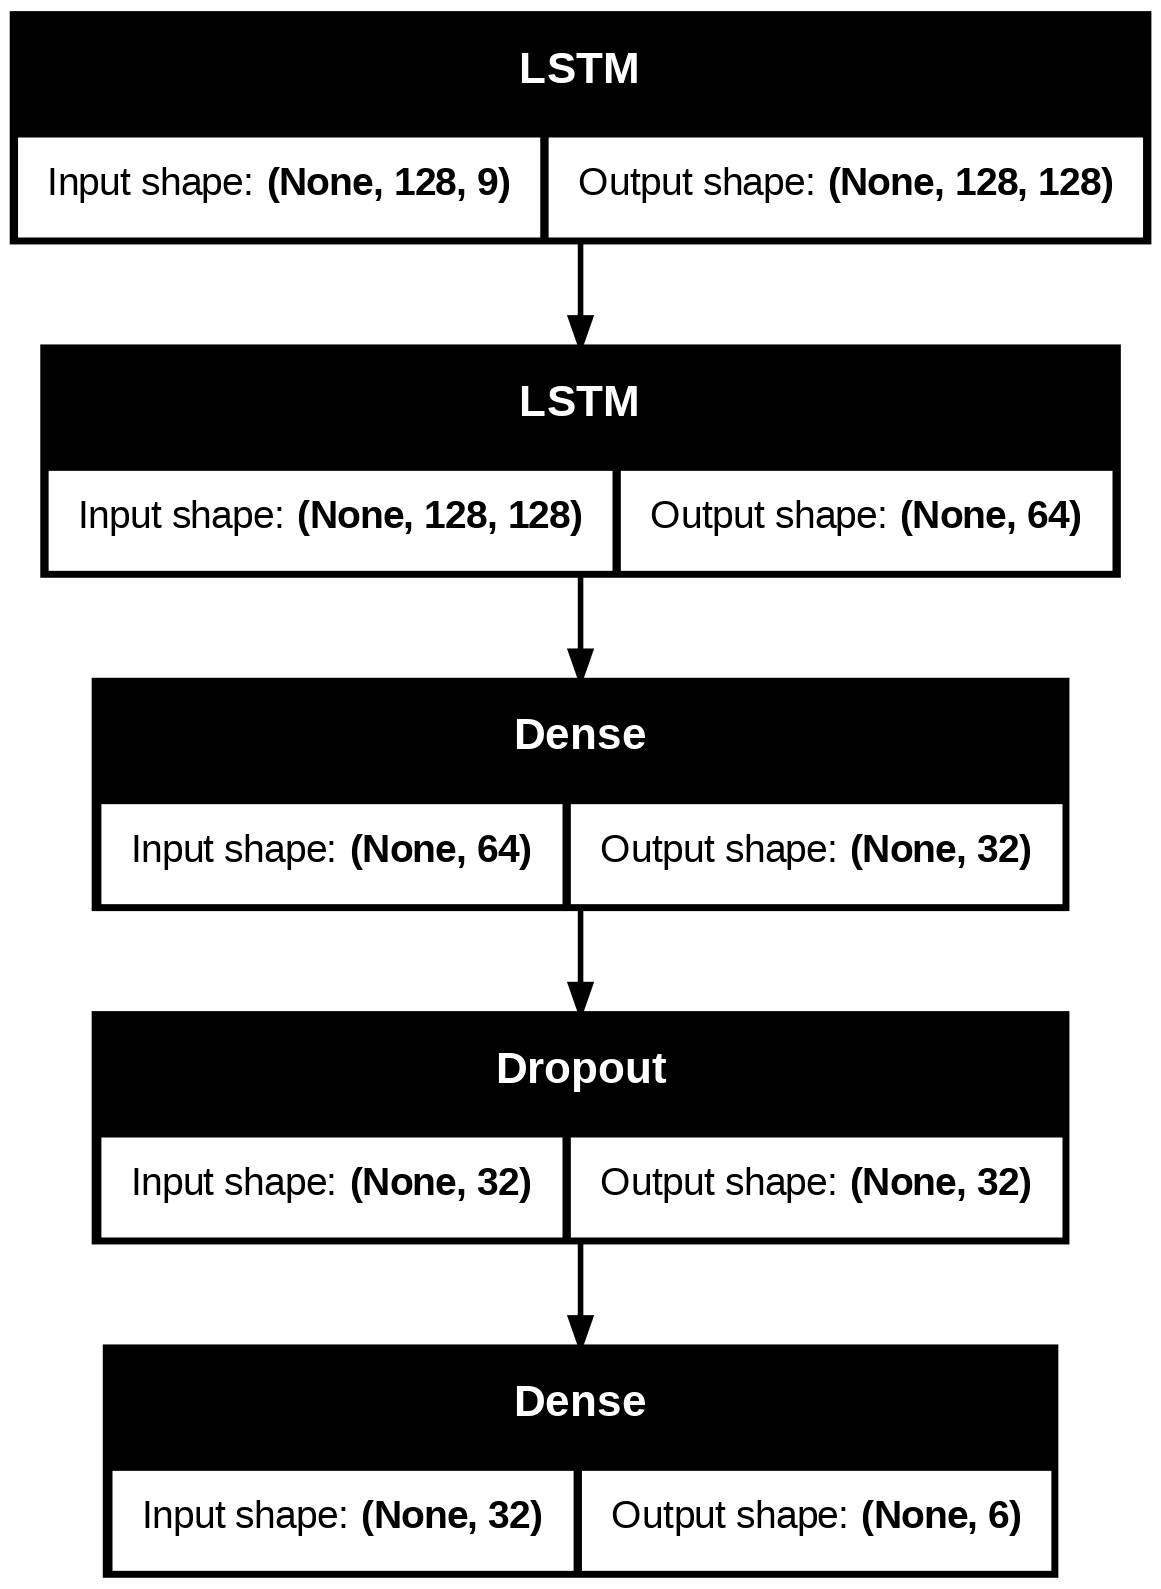

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_RNN_best.h5",
                save_best_only=True,
                monitor="sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 1.3533 - sparse_categorical_accuracy: 0.4345
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.51714, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 60s 243ms/step - loss: 1.3524 - sparse_categorical_accuracy: 0.4349
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.8767 - sparse_categorical_accuracy: 0.6140
Epoch 2: sparse_categorical_accuracy improved from 0.51714 to 0.62350, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 241ms/step - loss: 0.8767 - sparse_categorical_accuracy: 0.6141
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.7232 - sparse_categorical_accuracy: 0.7095
Epoch 3: sparse_categorical_accuracy improved from 0.62350 to 0.74116, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 55s 237ms/step - loss: 0.7229 - sparse_categorical_accuracy: 0.7096
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.4811 - sparse_categorical_accuracy: 0.8237
Epoch 4: sparse_categorical_accuracy improved from 0.74116 to 0.82413, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - loss: 0.4811 - sparse_categorical_accuracy: 0.8237
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.4383 - sparse_categorical_accuracy: 0.8356
Epoch 5: sparse_categorical_accuracy improved from 0.82413 to 0.83964, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 238ms/step - loss: 0.4383 - sparse_categorical_accuracy: 0.8356
Epoch 6/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.3647 - sparse_categorical_accuracy: 0.8605
Epoch 6: sparse_categorical_accuracy improved from 0.83964 to 0.86140, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 236ms/step - loss: 0.3647 - sparse_categorical_accuracy: 0.8605
Epoch 7/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.3782 - sparse_categorical_accuracy: 0.8547
Epoch 7: sparse_categorical_accuracy did not improve from 0.86140
230/230 ━━━━━━━━━━━━━━━━━━━━ 54s 236ms/step - loss: 0.3783 - sparse_categorical_accuracy: 0.8547
Epoch 8/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.3519 - sparse_categorical_accuracy: 0.8618
Epoch 8: sparse_categorical_accuracy improved from 0.86140 to 0.86534, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 234ms/step - loss: 0.3519 - sparse_categorical_accuracy: 0.8618
Epoch 9/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.2942 - sparse_categorical_accuracy: 0.8771
Epoch 9: sparse_categorical_accuracy improved from 0.86534 to 0.87568, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 236ms/step - loss: 0.2942 - sparse_categorical_accuracy: 0.8771
Epoch 10/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.2839 - sparse_categorical_accuracy: 0.8783
Epoch 10: sparse_categorical_accuracy improved from 0.87568 to 0.87690, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 237ms/step - loss: 0.2839 - sparse_categorical_accuracy: 0.8783
Epoch 11/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.2880 - sparse_categorical_accuracy: 0.8716
Epoch 11: sparse_categorical_accuracy did not improve from 0.87690
230/230 ━━━━━━━━━━━━━━━━━━━━ 83s 239ms/step - loss: 0.2880 - sparse_categorical_accuracy: 0.8716
Epoch 12/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.2588 - sparse_categorical_accuracy: 0.8858
Epoch 12: sparse_categorical_accuracy improved from 0.87690 to 0.88234, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 54s 235ms/step - loss: 0.2589 - sparse_categorical_accuracy: 0.8858
Epoch 13/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.2735 - sparse_categorical_accuracy: 0.8832
Epoch 13: sparse_categorical_accuracy did not improve from 0.88234
230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 241ms/step - loss: 0.2736 - sparse_categorical_accuracy: 0.8832
Epoch 14/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.2691 - sparse_categorical_accuracy: 0.8777
Epoch 14: sparse_categorical_accuracy did not improve from 0.88234
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 244ms/step - loss: 0.2691 - sparse_categorical_accuracy: 0.8777
Epoch 15/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.2497 - sparse_categorical_accuracy: 0.8960
Epoch 15: sparse_categorical_accuracy improved from 0.88234 to 0.89051, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 243ms/step - loss: 0.2497 - sparse_categorical_accuracy: 0.8960
Epoch 16/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.2526 - sparse_categorical_accuracy: 0.8883
Epoch 16: sparse_categorical_accuracy improved from 0.89051 to 0.89132, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 240ms/step - loss: 0.2525 - sparse_categorical_accuracy: 0.8883
Epoch 17/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.2380 - sparse_categorical_accuracy: 0.8903
Epoch 17: sparse_categorical_accuracy did not improve from 0.89132
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - loss: 0.2381 - sparse_categorical_accuracy: 0.8902
Epoch 18/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.2343 - sparse_categorical_accuracy: 0.8927
Epoch 18: sparse_categorical_accuracy improved from 0.89132 to 0.89431, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 243ms/step - loss: 0.2343 - sparse_categorical_accuracy: 0.8927
Epoch 19/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.2435 - sparse_categorical_accuracy: 0.8911
Epoch 19: sparse_categorical_accuracy did not improve from 0.89431
230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 241ms/step - loss: 0.2435 - sparse_categorical_accuracy: 0.8911
Epoch 20/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.2722 - sparse_categorical_accuracy: 0.8884
Epoch 20: sparse_categorical_accuracy did not improve from 0.89431
230/230 ━━━━━━━━━━━━━━━━━━━━ 55s 239ms/step - loss: 0.2722 - sparse_categorical_accuracy: 0.8883
Epoch 21/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.2617 - sparse_categorical_accuracy: 0.8889
Epoch 21: sparse_categorical_accuracy did not improve from 0.89431
230/230 ━━━━━━━━━━━━━━━━━━━━ 54s 234ms/step - loss: 0.2616 - sparse_categorical_accuracy: 0.8889
Epoch 22/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.2294 - sparse_cate

230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - loss: 0.2330 - sparse_categorical_accuracy: 0.9011
Epoch 24/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.2141 - sparse_categorical_accuracy: 0.9021
Epoch 24: sparse_categorical_accuracy did not improve from 0.90112
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - loss: 0.2142 - sparse_categorical_accuracy: 0.9021
Epoch 25/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.2093 - sparse_categorical_accuracy: 0.8981
Epoch 25: sparse_categorical_accuracy did not improve from 0.90112
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 243ms/step - loss: 0.2093 - sparse_categorical_accuracy: 0.8981
Epoch 26/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.2081 - sparse_categorical_accuracy: 0.9035
Epoch 26: sparse_categorical_accuracy improved from 0.90112 to 0.90438, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 243ms/step - loss: 0.2081 - sparse_categorical_accuracy: 0.9035
Epoch 27/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.2104 - sparse_categorical_accuracy: 0.8936
Epoch 27: sparse_categorical_accuracy did not improve from 0.90438
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 243ms/step - loss: 0.2104 - sparse_categorical_accuracy: 0.8936
Epoch 28/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.2155 - sparse_categorical_accuracy: 0.9050
Epoch 28: sparse_categorical_accuracy did not improve from 0.90438
230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 243ms/step - loss: 0.2155 - sparse_categorical_accuracy: 0.9050
Epoch 29/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.2276 - sparse_categorical_accuracy: 0.8963
Epoch 29: sparse_categorical_accuracy did not improve from 0.90438
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - loss: 0.2276 - sparse_categorical_accuracy: 0.8963
Epoch 30/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.2153 - sparse_cate

230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 238ms/step - loss: 0.2030 - sparse_categorical_accuracy: 0.9063
Epoch 34/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.2091 - sparse_categorical_accuracy: 0.9026
Epoch 34: sparse_categorical_accuracy did not improve from 0.90642
230/230 ━━━━━━━━━━━━━━━━━━━━ 55s 238ms/step - loss: 0.2091 - sparse_categorical_accuracy: 0.9026
Epoch 35/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.2023 - sparse_categorical_accuracy: 0.9046
Epoch 35: sparse_categorical_accuracy improved from 0.90642 to 0.90710, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 235ms/step - loss: 0.2023 - sparse_categorical_accuracy: 0.9046
Epoch 36/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.2072 - sparse_categorical_accuracy: 0.9050
Epoch 36: sparse_categorical_accuracy did not improve from 0.90710
230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 233ms/step - loss: 0.2072 - sparse_categorical_accuracy: 0.9050
Epoch 37/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.2166 - sparse_categorical_accuracy: 0.8986
Epoch 37: sparse_categorical_accuracy did not improve from 0.90710
230/230 ━━━━━━━━━━━━━━━━━━━━ 83s 237ms/step - loss: 0.2166 - sparse_categorical_accuracy: 0.8986
Epoch 38/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.1881 - sparse_categorical_accuracy: 0.9091
Epoch 38: sparse_categorical_accuracy did not improve from 0.90710
230/230 ━━━━━━━━━━━━━━━━━━━━ 83s 241ms/step - loss: 0.1881 - sparse_categorical_accuracy: 0.9091
Epoch 39/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.1951 - sparse_cate

230/230 ━━━━━━━━━━━━━━━━━━━━ 54s 235ms/step - loss: 0.1991 - sparse_categorical_accuracy: 0.9071
Epoch 42/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.2069 - sparse_categorical_accuracy: 0.9007
Epoch 42: sparse_categorical_accuracy did not improve from 0.90805
230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 242ms/step - loss: 0.2069 - sparse_categorical_accuracy: 0.9007
Epoch 43/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.1976 - sparse_categorical_accuracy: 0.8999
Epoch 43: sparse_categorical_accuracy did not improve from 0.90805
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - loss: 0.1977 - sparse_categorical_accuracy: 0.8999
Epoch 44/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.1866 - sparse_categorical_accuracy: 0.9137
Epoch 44: sparse_categorical_accuracy improved from 0.90805 to 0.91104, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 242ms/step - loss: 0.1866 - sparse_categorical_accuracy: 0.9137
Epoch 45/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.1989 - sparse_categorical_accuracy: 0.9137
Epoch 45: sparse_categorical_accuracy improved from 0.91104 to 0.91186, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 0.1989 - sparse_categorical_accuracy: 0.9137
Epoch 46/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.1957 - sparse_categorical_accuracy: 0.9112
Epoch 46: sparse_categorical_accuracy did not improve from 0.91186
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - loss: 0.1957 - sparse_categorical_accuracy: 0.9112
Epoch 47/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.2000 - sparse_categorical_accuracy: 0.9033
Epoch 47: sparse_categorical_accuracy did not improve from 0.91186
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - loss: 0.2000 - sparse_categorical_accuracy: 0.9033
Epoch 48/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.1847 - sparse_categorical_accuracy: 0.9088
Epoch 48: sparse_categorical_accuracy did not improve from 0.91186
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - loss: 0.1847 - sparse_categorical_accuracy: 0.9088
Epoch 49/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.1985 - sparse_cate

230/230 ━━━━━━━━━━━━━━━━━━━━ 54s 235ms/step - loss: 0.1789 - sparse_categorical_accuracy: 0.9155
Epoch 56/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.1735 - sparse_categorical_accuracy: 0.9159
Epoch 56: sparse_categorical_accuracy did not improve from 0.91240
230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 241ms/step - loss: 0.1736 - sparse_categorical_accuracy: 0.9159
Epoch 57/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.2032 - sparse_categorical_accuracy: 0.9046
Epoch 57: sparse_categorical_accuracy did not improve from 0.91240
230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 243ms/step - loss: 0.2032 - sparse_categorical_accuracy: 0.9046
Epoch 58/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.2039 - sparse_categorical_accuracy: 0.9066
Epoch 58: sparse_categorical_accuracy improved from 0.91240 to 0.91308, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 242ms/step - loss: 0.2038 - sparse_categorical_accuracy: 0.9066
Epoch 59/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.1741 - sparse_categorical_accuracy: 0.9163
Epoch 59: sparse_categorical_accuracy did not improve from 0.91308
230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 242ms/step - loss: 0.1742 - sparse_categorical_accuracy: 0.9163
Epoch 60/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.1858 - sparse_categorical_accuracy: 0.9133
Epoch 60: sparse_categorical_accuracy did not improve from 0.91308
230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 244ms/step - loss: 0.1858 - sparse_categorical_accuracy: 0.9133
Epoch 61/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.1718 - sparse_categorical_accuracy: 0.9067
Epoch 61: sparse_categorical_accuracy did not improve from 0.91308
230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 242ms/step - loss: 0.1718 - sparse_categorical_accuracy: 0.9067
Epoch 62/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.1989 - sparse_cate

230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - loss: 0.1731 - sparse_categorical_accuracy: 0.9155
Epoch 64/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.1766 - sparse_categorical_accuracy: 0.9121
Epoch 64: sparse_categorical_accuracy did not improve from 0.91404
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - loss: 0.1766 - sparse_categorical_accuracy: 0.9121
Epoch 65/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.1895 - sparse_categorical_accuracy: 0.9097
Epoch 65: sparse_categorical_accuracy did not improve from 0.91404
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - loss: 0.1895 - sparse_categorical_accuracy: 0.9097
Epoch 66/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.1758 - sparse_categorical_accuracy: 0.9102
Epoch 66: sparse_categorical_accuracy did not improve from 0.91404
230/230 ━━━━━━━━━━━━━━━━━━━━ 54s 234ms/step - loss: 0.1758 - sparse_categorical_accuracy: 0.9102
Epoch 67/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.2053 - sparse_cate

230/230 ━━━━━━━━━━━━━━━━━━━━ 55s 236ms/step - loss: 0.2011 - sparse_categorical_accuracy: 0.9047
Epoch 69/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.1975 - sparse_categorical_accuracy: 0.8972
Epoch 69: sparse_categorical_accuracy did not improve from 0.91417
230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 235ms/step - loss: 0.1974 - sparse_categorical_accuracy: 0.8973
Epoch 70/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.1946 - sparse_categorical_accuracy: 0.9088
Epoch 70: sparse_categorical_accuracy did not improve from 0.91417
230/230 ━━━━━━━━━━━━━━━━━━━━ 83s 239ms/step - loss: 0.1947 - sparse_categorical_accuracy: 0.9088
Epoch 71/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.1820 - sparse_categorical_accuracy: 0.9147
Epoch 71: sparse_categorical_accuracy improved from 0.91417 to 0.91662, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - loss: 0.1820 - sparse_categorical_accuracy: 0.9147
Epoch 72/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.1730 - sparse_categorical_accuracy: 0.9106
Epoch 72: sparse_categorical_accuracy did not improve from 0.91662
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - loss: 0.1730 - sparse_categorical_accuracy: 0.9106
Epoch 73/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.1976 - sparse_categorical_accuracy: 0.9099
Epoch 73: sparse_categorical_accuracy did not improve from 0.91662
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - loss: 0.1976 - sparse_categorical_accuracy: 0.9099
Epoch 74/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.1799 - sparse_categorical_accuracy: 0.9152
Epoch 74: sparse_categorical_accuracy did not improve from 0.91662
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - loss: 0.1799 - sparse_categorical_accuracy: 0.9151
Epoch 75/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.1766 - sparse_cate

230/230 ━━━━━━━━━━━━━━━━━━━━ 54s 235ms/step - loss: 0.1703 - sparse_categorical_accuracy: 0.9229
Epoch 77/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.1843 - sparse_categorical_accuracy: 0.9121
Epoch 77: sparse_categorical_accuracy did not improve from 0.91825
230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 242ms/step - loss: 0.1843 - sparse_categorical_accuracy: 0.9121
Epoch 78/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.1791 - sparse_categorical_accuracy: 0.9152
Epoch 78: sparse_categorical_accuracy did not improve from 0.91825
230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 242ms/step - loss: 0.1791 - sparse_categorical_accuracy: 0.9152
Epoch 79/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.1701 - sparse_categorical_accuracy: 0.9135
Epoch 79: sparse_categorical_accuracy did not improve from 0.91825
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - loss: 0.1701 - sparse_categorical_accuracy: 0.9135
Epoch 80/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.1795 - sparse_cate

230/230 ━━━━━━━━━━━━━━━━━━━━ 54s 236ms/step - loss: 0.1607 - sparse_categorical_accuracy: 0.9167
Epoch 87/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.1584 - sparse_categorical_accuracy: 0.9155
Epoch 87: sparse_categorical_accuracy did not improve from 0.91853
230/230 ━━━━━━━━━━━━━━━━━━━━ 55s 240ms/step - loss: 0.1584 - sparse_categorical_accuracy: 0.9155
Epoch 88/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.1822 - sparse_categorical_accuracy: 0.9109
Epoch 88: sparse_categorical_accuracy did not improve from 0.91853
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - loss: 0.1822 - sparse_categorical_accuracy: 0.9109
Epoch 89/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.1926 - sparse_categorical_accuracy: 0.9054
Epoch 89: sparse_categorical_accuracy did not improve from 0.91853
230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 237ms/step - loss: 0.1926 - sparse_categorical_accuracy: 0.9055
Epoch 90/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.1710 - sparse_cate

230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 242ms/step - loss: 0.1518 - sparse_categorical_accuracy: 0.9228
Epoch 92/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.1672 - sparse_categorical_accuracy: 0.9140
Epoch 92: sparse_categorical_accuracy did not improve from 0.92206
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - loss: 0.1672 - sparse_categorical_accuracy: 0.9140
Epoch 93/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.1870 - sparse_categorical_accuracy: 0.9119
Epoch 93: sparse_categorical_accuracy did not improve from 0.92206
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - loss: 0.1870 - sparse_categorical_accuracy: 0.9119
Epoch 94/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.1825 - sparse_categorical_accuracy: 0.9113
Epoch 94: sparse_categorical_accuracy did not improve from 0.92206
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - loss: 0.1825 - sparse_categorical_accuracy: 0.9113
Epoch 95/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.1605 - sparse_cate

230/230 ━━━━━━━━━━━━━━━━━━━━ 55s 239ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.9183
Epoch 99/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.9183
Epoch 99: sparse_categorical_accuracy did not improve from 0.92247
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.9183
Epoch 100/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.1492 - sparse_categorical_accuracy: 0.9278
Epoch 100: sparse_categorical_accuracy improved from 0.92247 to 0.92410, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - loss: 0.1492 - sparse_categorical_accuracy: 0.9278
Restoring model weights from the end of the best epoch: 100.


In [ ]:
# 모델 평가
model = tf.keras.models.load_model("UCI_HAR_RNN_best.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

Training accuracy: 87.36%
Training loss: 0.3342


model.predict
- 각 시퀀스 샘플마다, 모든 클래스에 대한 예측 확률 벡터
- y_pred_proba.shape -> (샘플 수, 클래스 수)

np.argmax
- 최대 값의 인덱스를 선택 = 라벨

In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9496    0.9741       496
           1     0.9833    1.0000    0.9916       471
           2     0.9523    0.9976    0.9744       420
           3     0.6188    0.7902    0.6941       491
           4     0.8431    0.8684    0.8556       532
           5     0.9607    0.6834    0.7987       537

    accuracy                         0.8748      2947
   macro avg     0.8930    0.8815    0.8814      2947
weighted avg     0.8915    0.8748    0.8769      2947



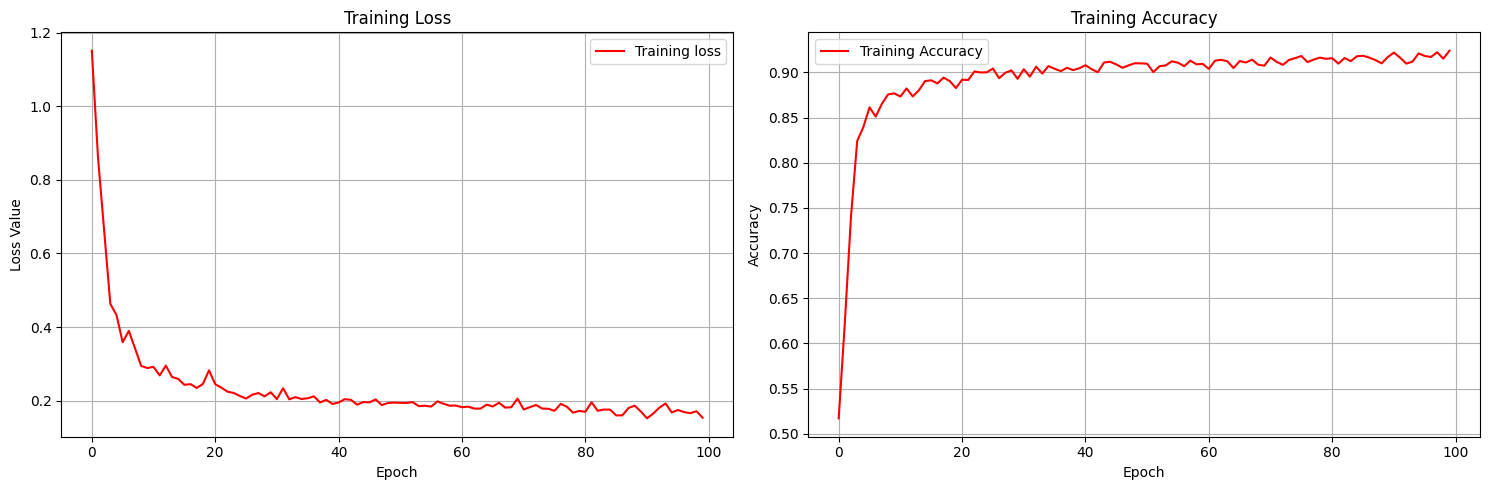

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

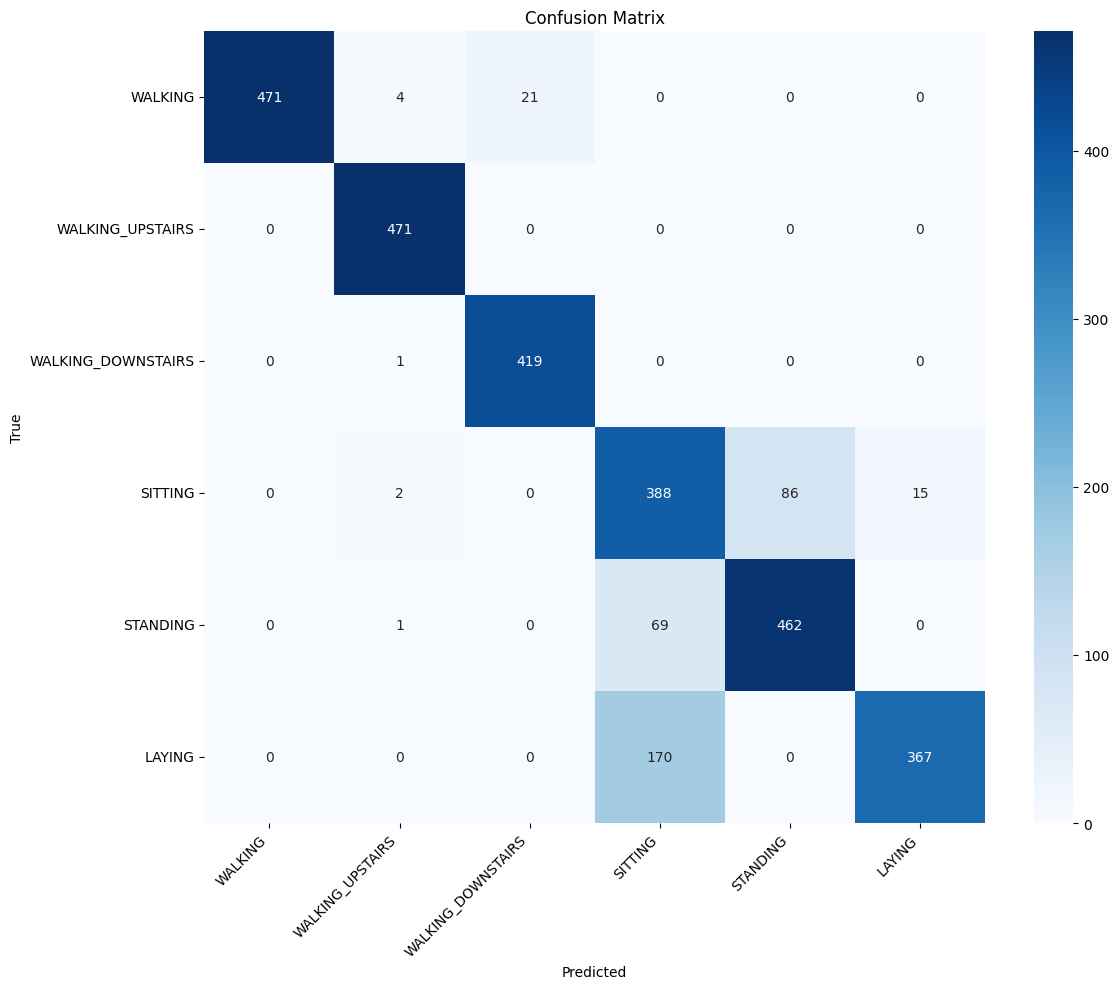

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()